In [1]:
import numpy as np
import pandas as pd
import sklearn
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
data = pd.read_csv("recruitmentdataset-2022-1.3.csv")

In [84]:
D_data = data[(data['company'] == 'D') & (data['sport'].isin(['Swimming', 'Football', 'Golf']))]
D_data = D_data.drop(columns=['company','Id'])
D_data.info()
D_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 474 non-null    object
 1   age                    474 non-null    int64 
 2   nationality            474 non-null    object
 3   sport                  474 non-null    object
 4   ind-university_grade   474 non-null    int64 
 5   ind-debateclub         474 non-null    bool  
 6   ind-programming_exp    474 non-null    bool  
 7   ind-international_exp  474 non-null    bool  
 8   ind-entrepeneur_exp    474 non-null    bool  
 9   ind-languages          474 non-null    int64 
 10  ind-exact_study        474 non-null    bool  
 11  ind-degree             474 non-null    object
 12  decision               474 non-null    bool  
dtypes: bool(6), int64(3), object(4)
memory usage: 32.4+ KB


,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision
3000,female,28,Dutch,Golf,65,False,False,True,False,1,False,phd,True
3001,female,22,Dutch,Football,70,False,True,False,False,1,True,master,True
3004,female,21,Dutch,Football,66,False,False,False,True,2,False,bachelor,True
3005,female,25,Dutch,Swimming,68,False,True,False,False,0,True,master,False
3006,male,31,Dutch,Football,67,False,True,False,False,2,True,master,True


# Data exploration

In [85]:
min_max_values = D_data.agg({
    'age': ['min', 'max'],
    'ind-university_grade': ['min', 'max'],
    'ind-languages': ['min', 'max']
})

min_max_values.rename(index={'min': 'Minimum', 'max': 'Maximum'}, inplace=True)
min_max_values.columns = ['Age', 'University Grade', 'Number of Languages']
min_max_values

,Age,University Grade,Number of Languages
Minimum,21,48,0
Maximum,32,78,3


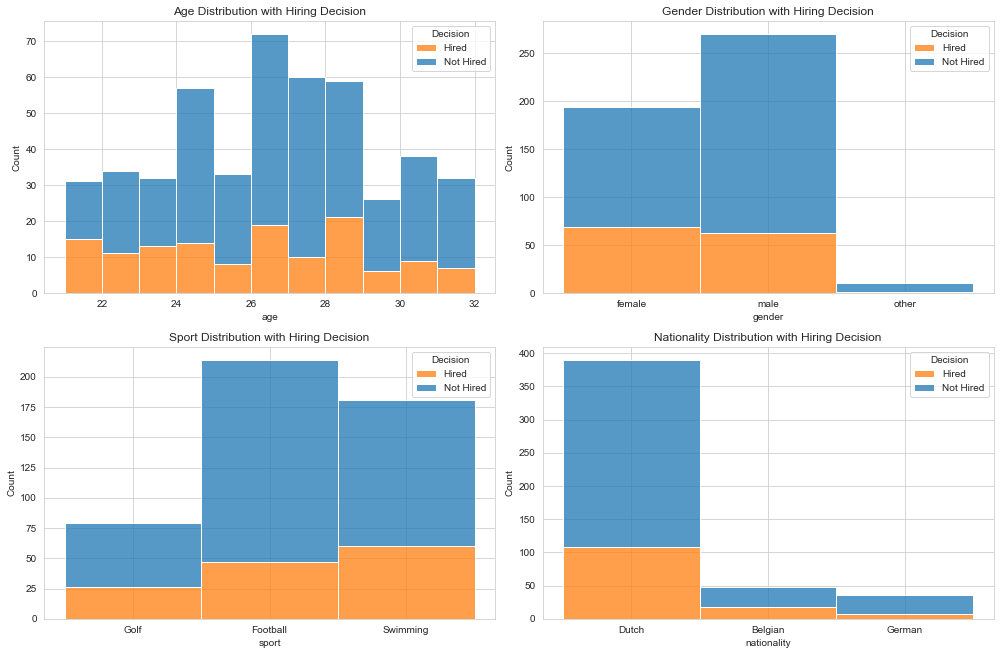

In [86]:
sns.set_style("whitegrid")


# Visualize data distributions and potential outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
sns.histplot(data=D_data, x='age', hue='decision', multiple="stack", ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution with Hiring Decision')
axes[0, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])
           
# gender distribution
sns.histplot(data=D_data, x='gender', hue='decision', multiple="stack", binwidth=1, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution with Hiring Decision')
axes[0, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])

# sport distribution
sns.histplot(data=D_data, x='sport',hue='decision', multiple="stack", bins=4, ax=axes[1, 0])
axes[1, 0].set_title('Sport Distribution with Hiring Decision')
axes[1, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])

# Nationality Distribution
sns.histplot(data=D_data, x='nationality', hue='decision', multiple="stack", ax=axes[1, 1])
axes[1, 1].set_title('Nationality Distribution with Hiring Decision')
axes[1, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

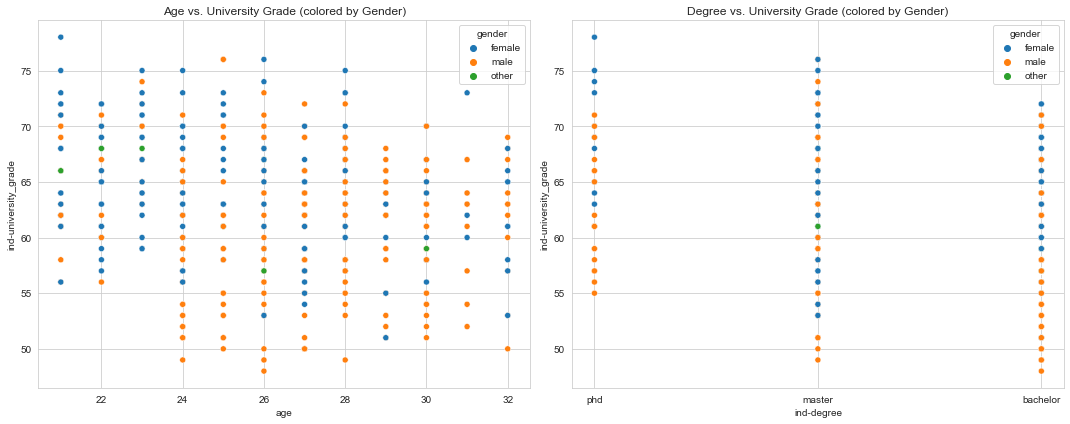

In [87]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=D_data, x='age', y='ind-university_grade', hue='gender', marker='o')
plt.title('Age vs. University Grade (colored by Gender)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=D_data, x='ind-degree', y='ind-university_grade', hue='gender', marker='o')
plt.title('Degree vs. University Grade (colored by Gender)')

plt.tight_layout()
plt.show()

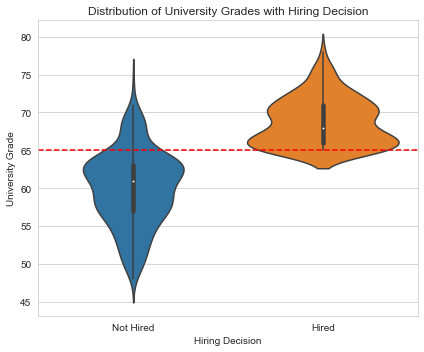

In [88]:
plt.figure(figsize=(6, 5))

sns.violinplot(data=D_data, x='decision', y='ind-university_grade')
plt.title('Distribution of University Grades with Hiring Decision')
plt.xlabel("Hiring Decision")
plt.ylabel("University Grade")
plt.xticks(ticks=[False, True], labels=['Not Hired', 'Hired'])
plt.axhline(y=65, color='r', linestyle='--', label='y=65')

plt.tight_layout()
plt.show()

- The median grade of hired candidates is visibly higher than that of non-hired candidates. The minimum grade requirement >=65 in relation to hiring decisions.

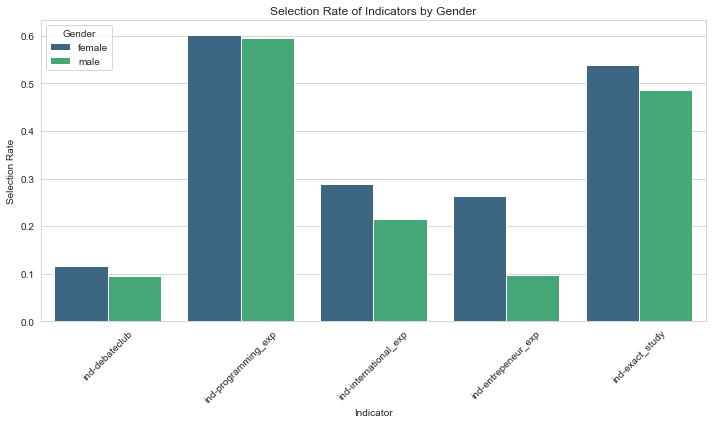

In [89]:
gender_data = D_data[D_data['gender'].isin(['female', 'male'])]

indicators = [
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-exact_study'
]

# Calculate selection rates for each indicator and gender
selection_rates_gender = pd.DataFrame()

for ind in indicators:
    rates = gender_data[gender_data[ind] == True].groupby('gender')['decision'].mean().reset_index()
    rates['indicator'] = ind
    selection_rates_gender = pd.concat([selection_rates_gender, rates], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(data=selection_rates_gender, x='indicator', y='decision', hue='gender', palette="viridis", ci=None)
plt.title('Selection Rate of Indicators by Gender')
plt.xlabel('Indicator')
plt.ylabel('Selection Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

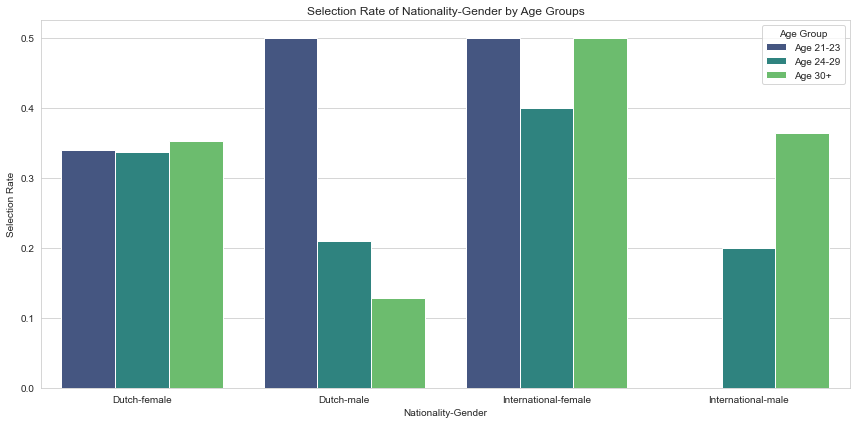

In [90]:
bins = [47, 64, 69, 100]  # The bins will be 65-69, 70+
labels = ['Grade 48-64', 'Grade 65-69', 'Grade 70+']
D_data['grade_group'] = pd.cut(D_data['ind-university_grade'], bins=bins, labels=labels, right=True)

bins = [20, 23, 29, 100]  # The bins will be 21-23, 24-29, 30+
labels = ['Age 21-23', 'Age 24-29', 'Age 30+']
D_data['age_group'] = pd.cut(D_data['age'], bins=bins, labels=labels, right=True)

# Simplify nationality and filter data for specified genders
D_data['simple_nationality'] = D_data['nationality'].apply(lambda x: 'Dutch' if x == 'Dutch' else 'International')
filtered_data = D_data[D_data['gender'].isin(['female', 'male'])].copy()  # Creating a copy to avoid warnings

# Create a combined Nationality-Gender column
filtered_data['nationality_gender'] = filtered_data['simple_nationality'] + '-' + filtered_data['gender']

# Calculate selection rates for each Nationality-Gender and Age Group
selection_rates_natgen_age = filtered_data.groupby(['nationality_gender', 'age_group'])['decision'].mean().reset_index()

# Bar chart to visualize selection rates of Nationality-Gender by Age Groups
plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_age, x='nationality_gender', y='decision', hue='age_group', palette="viridis", ci=None)
plt.title('Selection Rate of Nationality-Gender by Age Groups')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

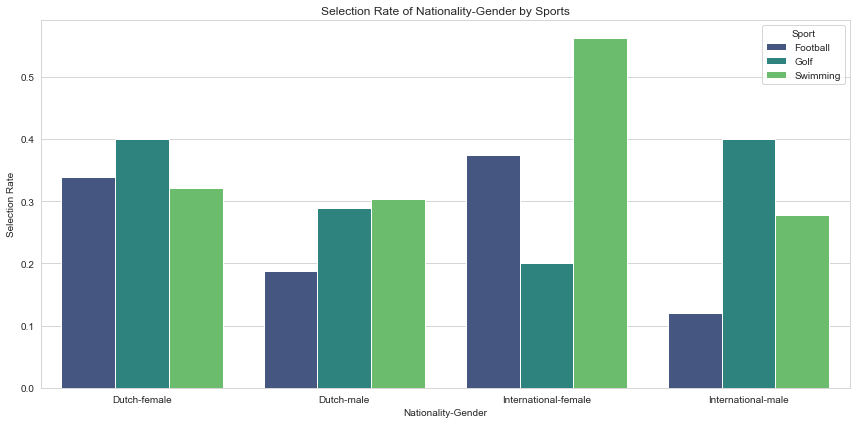

In [91]:
# Calculate selection rates for each Nationality-Gender and Sport
selection_rates_natgen_sport = filtered_data.groupby(['nationality_gender', 'sport'])['decision'].mean().reset_index()

# Bar chart to visualize selection rates of Nationality-Gender by Sports
plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_sport, x='nationality_gender', y='decision', hue='sport', palette="viridis", ci=None)
plt.title('Selection Rate of Nationality-Gender by Sports')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Sport')
plt.tight_layout()
plt.show()


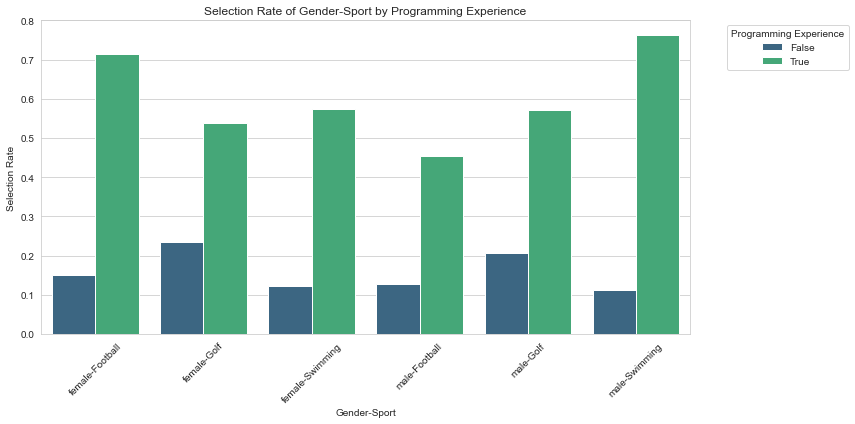

In [92]:
# Create a copy of the filtered data to avoid warnings
filtered_data_copy = filtered_data.copy()

filtered_data_copy.loc[:, 'gender_sport'] = filtered_data_copy['gender'] + '-' + filtered_data_copy['sport'].astype(str)

# Calculate selection rates for each Gender-Sport and Programming Experience
selection_rates_gensport_prog = filtered_data_copy.groupby(['gender_sport', 'ind-programming_exp'])['decision'].mean().reset_index()

# Bar chart visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_gensport_prog, x='gender_sport', y='decision', hue='ind-programming_exp', palette="viridis", ci=None)
plt.title('Selection Rate of Gender-Sport by Programming Experience')
plt.xlabel('Gender-Sport')
plt.ylabel('Selection Rate')
plt.legend(title='Programming Experience', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

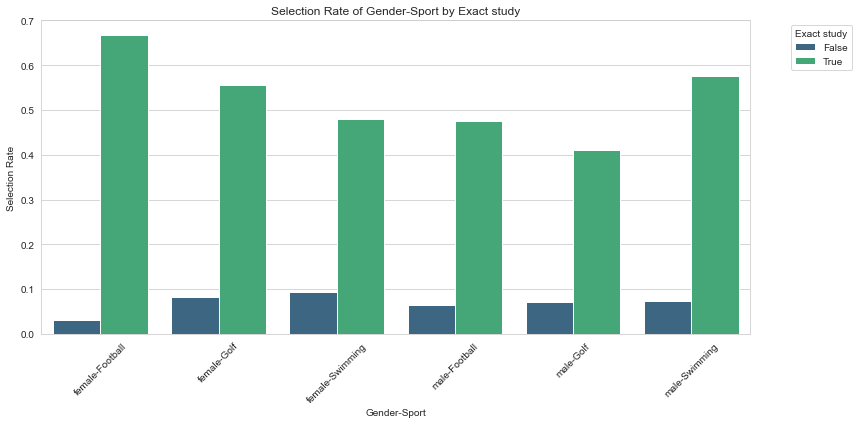

In [93]:
# Create a copy of the filtered data to avoid warnings
filtered_data_copy = filtered_data.copy()

filtered_data_copy.loc[:, 'gender_sport'] = filtered_data_copy['gender'] + '-' + filtered_data_copy['sport'].astype(str)

# Calculate selection rates for each Gender-Sport and Programming Experience
selection_rates_gensport_study = filtered_data_copy.groupby(['gender_sport', 'ind-exact_study'])['decision'].mean().reset_index()

# Bar chart visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_gensport_study, x='gender_sport', y='decision', hue='ind-exact_study', palette="viridis", ci=None)
plt.title('Selection Rate of Gender-Sport by Exact study')
plt.xlabel('Gender-Sport')
plt.ylabel('Selection Rate')
plt.legend(title='Exact study', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

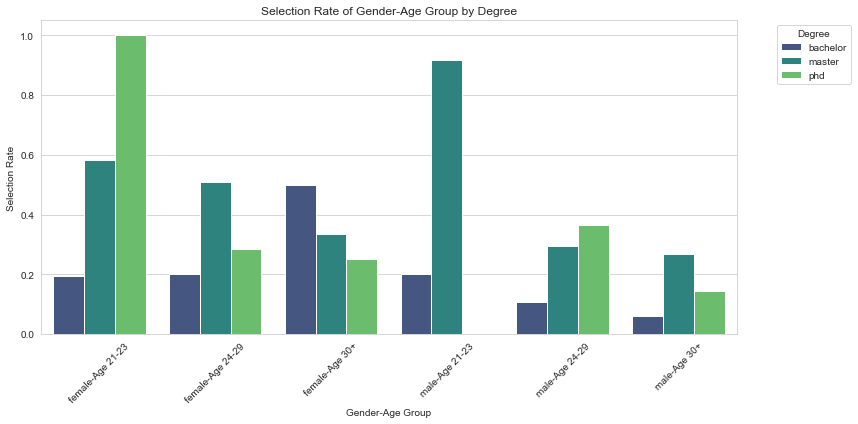

In [94]:
# 1. Bar Chart: Selection Rate of Gender-AgeGroup by Degree

# Create a combined Gender-AgeGroup column using .loc
filtered_data_copy.loc[:, 'gender_agegroup'] = filtered_data_copy['gender'] + '-' + filtered_data_copy['age_group'].astype(str)

# Calculate selection rates for each Gender-AgeGroup and Degree
selection_rates_genage_degree = filtered_data_copy.groupby(['gender_agegroup', 'ind-degree'])['decision'].mean().reset_index()

# Bar chart visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_genage_degree, x='gender_agegroup', y='decision', hue='ind-degree', palette="viridis", ci=None)
plt.title('Selection Rate of Gender-Age Group by Degree')
plt.xlabel('Gender-Age Group')
plt.ylabel('Selection Rate')
plt.legend(title='Degree', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Comparison of Selection rates of Subgroups

In [95]:
filtered_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 3000 to 3999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 464 non-null    object  
 1   age                    464 non-null    int64   
 2   nationality            464 non-null    object  
 3   sport                  464 non-null    object  
 4   ind-university_grade   464 non-null    int64   
 5   ind-debateclub         464 non-null    bool    
 6   ind-programming_exp    464 non-null    bool    
 7   ind-international_exp  464 non-null    bool    
 8   ind-entrepeneur_exp    464 non-null    bool    
 9   ind-languages          464 non-null    int64   
 10  ind-exact_study        464 non-null    bool    
 11  ind-degree             464 non-null    object  
 12  decision               464 non-null    bool    
 13  grade_group            464 non-null    category
 14  age_group              464 non-null   

In [99]:
filtered_data_copy.nationality_gender_prog.value_counts()

Dutch-male-non-programming              169
Dutch-female-non-programming             92
Dutch-female-programming                 73
Dutch-male-programming                   48
International-male-non-programming       44
International-female-programming         15
International-female-non-programming     14
International-male-programming            9
Name: nationality_gender_prog, dtype: int64

In [96]:
filtered_data_copy['nationality_gender_prog'] = filtered_data_copy['nationality_gender'] + '-' + filtered_data_copy['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data_copy['nationality_gender_exact'] = filtered_data_copy['nationality_gender'] + '-' + filtered_data_copy['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')
filtered_data_copy['nationality_gender_grade'] = filtered_data_copy['nationality_gender'] + '-' + filtered_data_copy['grade_group'].astype(str)
filtered_data_copy['nationality_gender_degree'] = filtered_data_copy['nationality_gender']  + '-' + filtered_data_copy['ind-degree'].astype(str)
filtered_data_copy['gender_sport_prog'] = filtered_data_copy['gender_sport']  + '-' + filtered_data_copy['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data_copy['gender_sport_exact'] = filtered_data_copy['gender_sport']  + '-' + filtered_data_copy['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')

filtered_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 3000 to 3999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     464 non-null    object  
 1   age                        464 non-null    int64   
 2   nationality                464 non-null    object  
 3   sport                      464 non-null    object  
 4   ind-university_grade       464 non-null    int64   
 5   ind-debateclub             464 non-null    bool    
 6   ind-programming_exp        464 non-null    bool    
 7   ind-international_exp      464 non-null    bool    
 8   ind-entrepeneur_exp        464 non-null    bool    
 9   ind-languages              464 non-null    int64   
 10  ind-exact_study            464 non-null    bool    
 11  ind-degree                 464 non-null    object  
 12  decision                   464 non-null    bool    
 13  grade_group                464 

In [110]:
subgroup_list = [
    'nationality_gender_prog', 
    'nationality_gender_exact', 
    'nationality_gender_grade', 
    'nationality_gender_degree', 
    'gender_sport_prog', 
    'gender_sport_exact'
]

subgroup_summary_corrected = pd.DataFrame(columns=['Subgroup', 'Category', 'Total', 'Selected', 'Rate'])

# Recalculate metrics for each subgroup
for subgroup in subgroup_list:
    # Group by the subgroup and calculate metrics
    subgroup_data = filtered_data_copy.groupby(subgroup)['decision'].agg(['count', 'sum']).reset_index()
    subgroup_data['Rate'] = subgroup_data['sum'] / subgroup_data['count']
    
    # Rename columns for clarity and consistency
    subgroup_data.columns = ['Category', 'Total', 'Selected', 'Rate']
    subgroup_data['Subgroup'] = subgroup
    
    # Append to the summary DataFrame
    subgroup_summary_corrected = pd.concat([subgroup_summary_corrected, subgroup_data], ignore_index=True)

subgroup_summary_corrected = subgroup_summary_corrected.sort_values(by=['Rate'], ascending=False)

subgroup_summary_corrected.head(20)  # Displaying first 15 rows for a quick view


,Subgroup,Category,Total,Selected,Rate
27,nationality_gender_grade,International-male-Grade 70+,3,3,1.0
24,nationality_gender_grade,International-female-Grade 70+,7,7,1.0
18,nationality_gender_grade,Dutch-female-Grade 70+,32,29,0.90625
21,nationality_gender_grade,Dutch-male-Grade 70+,21,18,0.857143
5,nationality_gender_prog,International-female-programming,15,12,0.8
51,gender_sport_prog,male-Swimming-programming,21,16,0.761905
26,nationality_gender_grade,International-male-Grade 65-69,12,9,0.75
20,nationality_gender_grade,Dutch-male-Grade 65-69,45,33,0.733333
41,gender_sport_prog,female-Football-programming,21,15,0.714286
35,nationality_gender_degree,International-female-master,15,10,0.666667


# Model

In [100]:
# Using get_dummies for One-Hot Encoding and keeping original column names
D_data_encoded = pd.get_dummies(D_data, columns=['gender', 'nationality', 'sport'], prefix=['', '', ''], prefix_sep='')

# Integer Encoding for 'ind-degree' column
degree_mapping = {'bachelor': 0, 'master': 1, 'phd': 2}
D_data_encoded['ind-degree'] = D_data_encoded['ind-degree'].map(degree_mapping)

# Displaying the transformed data
D_data_encoded.head()


,age,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision,...,simple_nationality,female,male,other,Belgian,Dutch,German,Football,Golf,Swimming
3000,28,65,False,False,True,False,1,False,2,True,...,Dutch,1,0,0,0,1,0,0,1,0
3001,22,70,False,True,False,False,1,True,1,True,...,Dutch,1,0,0,0,1,0,1,0,0
3004,21,66,False,False,False,True,2,False,0,True,...,Dutch,1,0,0,0,1,0,1,0,0
3005,25,68,False,True,False,False,0,True,1,False,...,Dutch,1,0,0,0,1,0,0,0,1
3006,31,67,False,True,False,False,2,True,1,True,...,Dutch,0,1,0,0,1,0,1,0,0


In [101]:
D_data_encoded.corr().decision.sort_values()

ind-debateclub          -0.230584
ind-entrepeneur_exp     -0.186145
Football                -0.123104
male                    -0.121007
age                     -0.101828
other                   -0.059008
German                  -0.054970
ind-international_exp   -0.047444
ind-languages           -0.040900
Dutch                   -0.017590
Golf                     0.048299
Belgian                  0.070535
Swimming                 0.089044
female                   0.139097
ind-degree               0.228985
ind-programming_exp      0.467205
ind-exact_study          0.490230
ind-university_grade     0.658698
decision                 1.000000
Name: decision, dtype: float64

In [102]:
D_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    474 non-null    int64   
 1   ind-university_grade   474 non-null    int64   
 2   ind-debateclub         474 non-null    bool    
 3   ind-programming_exp    474 non-null    bool    
 4   ind-international_exp  474 non-null    bool    
 5   ind-entrepeneur_exp    474 non-null    bool    
 6   ind-languages          474 non-null    int64   
 7   ind-exact_study        474 non-null    bool    
 8   ind-degree             474 non-null    int64   
 9   decision               474 non-null    bool    
 10  grade_group            474 non-null    category
 11  age_group              474 non-null    category
 12  simple_nationality     474 non-null    object  
 13  female                 474 non-null    uint8   
 14  male                   474 non-null   

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV, validation_curve

In [105]:
X = D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 
                                 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp', 'simple_nationality'])
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=7, random_state=42)
0.9139967144845194


In [140]:
X = D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 
                                 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp', 
                                 'simple_nationality', 'age', 'other'])
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, random_state=42)
0.9132751866148758


In [142]:
X = D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 
                                 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp',
                                 'simple_nationality', 'age', 'other'])
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, min_samples_split=10, random_state=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       103
        True       0.85      0.85      0.85        40

    accuracy                           0.92       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.92      0.92      0.92       143



In [122]:
X = D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 
                                 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp',
                                 'simple_nationality'])
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model = DecisionTreeClassifier(random_state=42, max_depth=2, min_samples_leaf=2, min_samples_split=2)

model.fit(X_train, y_train)
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.99      0.92      0.95       103
        True       0.83      0.97      0.90        40

    accuracy                           0.94       143
   macro avg       0.91      0.95      0.93       143
weighted avg       0.94      0.94      0.94       143



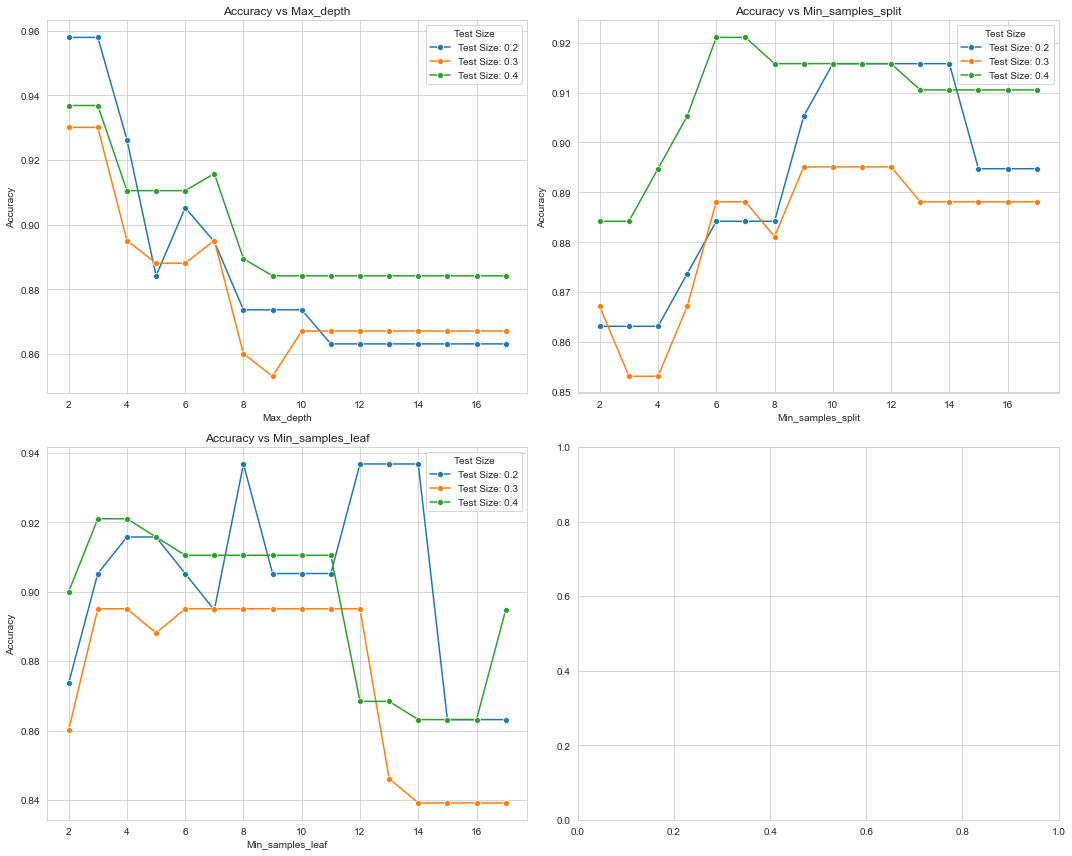

In [137]:
# Initialize figures for plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
axes = axes.ravel()

test_sizes = [0.2, 0.3, 0.4]

# Hyperparameters to be varied for analysis
hyperparam_values = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 18, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

input_variations = {
    'Input One': D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 'simple_nationality',
                                              'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp']),
    'Input Two': D_data_encoded.drop(columns=['decision', 'age_group', 'grade_group', 'simple_nationality',
                                              'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp', 'age', 'other'])
}

# Using Input One for the analysis
X = input_variations['Input Two']

# Loop through each hyperparameter and test size to plot accuracy
for ax_idx, (hyperparam, values) in enumerate(hyperparam_values.items()):
    for test_size in test_sizes:
        accuracies = []
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)
        
        # Vary the hyperparameter and measure accuracy
        for value in values:
            dt_temp = DecisionTreeClassifier(random_state=0, **{hyperparam: value})
            dt_temp.fit(X_train, y_train)
            acc = accuracy_score(y_test, dt_temp.predict(X_test))
            accuracies.append((test_size, value, acc))
        
        # Convert results into a DataFrame for easy plotting
        acc_df = pd.DataFrame(accuracies, columns=['test_size', hyperparam, 'accuracy'])
        
        # Plot
        sns.lineplot(x=hyperparam, y='accuracy', data=acc_df[acc_df['test_size'] == test_size], 
                     label=f'Test Size: {test_size}', ax=axes[ax_idx], marker='o')
        
        axes[ax_idx].set_title(f'Accuracy vs {hyperparam.capitalize()}')
        axes[ax_idx].set_xlabel(hyperparam.capitalize())
        axes[ax_idx].set_ylabel('Accuracy')
        axes[ax_idx].legend(title='Test Size')

plt.tight_layout()
plt.show()
